# Usage example: Simulated fMRI multiverse

This script will create perform the multiverse analysis as shown in Section 4 of the [preprint](https://www.biorxiv.org/content/10.1101/2024.01.21.576546v1).

Brief outline:

* Simulated time series data with two randomly changing connectivity patterns (7.2 second trial lengths)
* Connectivity patterns are predicted from graph measures that are calculated from dFC data on a trial-by-trial basis
* Multiverse options: dFC methods (6), temporal lag (2), graph density (2), graph weights (2), SVC kernel (2) --> 96 universes  

In [1]:
from comet.multiverse import Multiverse

forking_paths = {
    "dfc_method": [ # Dynamic functional connectivity measures
        {
            "name": "TSW21",
            "func": "comet.connectivity.SlidingWindow(time_series=ts_hp, windowsize=21, shape='gaussian', std=7).estimate()"
        },
        {
            "name": "SD",
            "func": "comet.connectivity.SpatialDistance(time_series=ts_hp, dist='euclidean').estimate()"
        },
        {
            "name": "MTD7",
            "func": "comet.connectivity.TemporalDerivatives(time_series=ts_hp, windowsize=7).estimate()"
        },
        {
            "name": "PSc",
            "func": "comet.connectivity.PhaseSynchrony(time_series=ts_hp, method='crp').estimate()"
        },
        {
            "name": "FLS",
            "func": "comet.connectivity.FlexibleLeastSquares(time_series=ts_hp, standardizeData=True, mu=50, num_cores=8, progress_bar=False).estimate()"
        }],
    "tr": [0.72],               # TR in seconds (not a forking path, but useful as a global parameter)
    "segment_length": [10],     # Length of each trial segment (in TRs, not a forking path, but useful as a global parameter)
    "delay": [6, 10],           # Shift to account for hemodynamic delay (in TR) -> delay*0.72 = 3/5 seconds
    "density": [0.5, 0.25],     # Graph density (keep top X% of edges)
    "binarise": [True, False],  # Graph binarisation (otherwise weighted)
    "graph_measure": [          # Graph measures
        {
            "name": "participation",
            "func": "comet.graph.participation_coef(G, ci='louvain')"
        },
        {
            "name": "clustering",
            "func": "comet.graph.clustering_coef(G)"
        },
        {
            "name": "efficiency",
            "func": "comet.graph.efficiency(G, local=True)"
        }],
    "svc_kernel": ["'linear'", "'rbf'"] # SVC kernel
}


With the forking paths defined, the analysis pipeline template can be created. Please not that the ```tr``` and ```segment_length``` parameters were also defined in the forking paths to allow for easy changes if necessary.

In [2]:
def analysis_template():
    import comet
    import numpy as np
    from sklearn.svm import SVC
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score
    from joblib import Parallel, delayed
    
    #####################################
    # 1. LOAD DATA AND EXTRACT PARAMETERS
    data_sim = comet.utils.load_example("simulation.pkl")
    ts_sim = data_sim[0] # time series data
    time = data_sim[1]   # time in seconds
    onsets = data_sim[2] # trial onsets in seconds
    labels = data_sim[3] # trial labels (connectivity state)

    ###############################################
    # 2. DFC CALCULATION (DECISION: DFC METHOD)
    # Preprocessing. Phase-based methods require band-pass filtering, amplitude-based methods require high-pass filtering.
    ts_bp = comet.utils.clean(ts_sim, confounds=None, t_r={{tr}}, detrend=True, standardize=False, \
                             high_pass=0.03, low_pass=0.07) # band pass (narrow-band signal for Hilbert transform)
    ts_hp = comet.utils.clean(ts_sim, confounds=None, t_r={{tr}}, detrend=True, standardize=False, \
                             high_pass=0.01)                # high pass (for amplitude based methods)

    # Estimate dFC
    dfc_ts = {{dfc_method}}

    #######################################
    # 3. SEGMENT DATA (DECISION: DELAY)
    segments = []
    for i in onsets:
        segment = [i+j+{{delay}} for j in range(0, {{segment_length}})]
        segments.append(segment)

    segments = np.asarray(segments).astype(int)
    labels = np.asarray(labels).astype(int)

    # IMPORTANT! Handle the different lenghts of dfc time series as windowing methods will produce shorter dFC time series
    windowsize = ts_sim.shape[0] - dfc_ts.shape[2] + 1
    offset = windowsize // 2
    segments = np.asarray(segments) - offset

    index = []
    features = []
    behaviour = []

    # Get the trial segments (this only checks if we are outside the allowed bounds, otherwise we just keep all segments/labels)
    for segment, label in zip(segments, labels):
        if segment[0] > 0 and segment[-1] < dfc_ts.shape[2]: # make sure the trial is covered by the dfc data
            matrices = dfc_ts[:,:,segment]
            matrix = np.mean(matrices, axis=2) # average over the dFC estimates to reduce noise and get a single estimate for each trial

            features.append(matrix)
            behaviour.append(label)
            index.append(segment)
        else:
            raise ValueError(f"Segment {segment} not covered by data, aborting calculations.")

    index = np.asarray(index)
    features = np.asarray(features)
    behaviour = np.asarray(behaviour)

    ####################################################################
    # 4. CALCULATE GRAPH MEASURES (DECISIONS: DENSITY, BINARISATION)
    def compute_graph_measures(t, features, index, density, binarise):
        G = np.asarray(features[t, :, :]).copy()
        G = comet.graph.handle_negative_weights(G, type="absolute")
        G = comet.graph.threshold(G, type="density", density=density)
        G = comet.graph.postproc(G)

        graph_results = {{graph_measure}}

        return graph_results

    graph_results = Parallel(n_jobs=4)(delayed(compute_graph_measures)(t, features, index, {{density}}, {{binarise}}) for t in range(features.shape[0]))

    # Unpack the results
    features = []
    for result in graph_results:
        features.append(result)

    ##############################################
    # 5. CLASSIFICATION (DECISION: SVC KERNEL)
    features = np.asarray(features)
    labels = behaviour

    # Initialize the SVC
    svc = SVC(kernel={{svc_kernel}})

    # Perform 5-fold cross-validation
    accuracy = []
    skf = StratifiedKFold(n_splits=5)

    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_pred))

    accuracy = np.asarray(accuracy)

    # Save the result (pediction accuracy for each fold)
    result = {"prediction\naccuracy": accuracy}
    comet.utils.save_universe_results(result)

Create (and if required run) the multiverse analysis:

In [3]:
mverse = Multiverse(name="example_mv_fmri_sim")
mverse.create(analysis_template, forking_paths)
mverse.run(parallel=4)

Starting multiverse analysis for all universes...


  0%|          | 0/240 [00:00<?, ?it/s]

The multiverse analysis completed without any errors.


As the results from the multiverse analysis are already provided, we can explore and visualize the multiverse:

,Universe,Decision 1,Value 1,Decision 2,Value 2,Decision 3,Value 3,Decision 4,Value 4,Decision 5,Value 5,Decision 6,Value 6,Decision 7,Value 7,Decision 8,Value 8
0,Universe_1,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,participation,svc_kernel,'linear'
1,Universe_2,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,participation,svc_kernel,'rbf'
2,Universe_3,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,clustering,svc_kernel,'linear'
3,Universe_4,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,clustering,svc_kernel,'rbf'
4,Universe_5,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,efficiency,svc_kernel,'linear'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Universe_236,dfc_method,FLS,tr,0.72,segment_length,10,delay,10,density,0.25,binarise,False,graph_measure,participation,svc_kernel,'rbf'
236,Universe_237,dfc_method,FLS,tr,0.72,segment_length,10,delay,10,density,0.25,binarise,False,graph_measure,clustering,svc_kernel,'linear'
237,Universe_238,dfc_method,FLS,tr,0.72,segment_length,10,delay,10,density,0.25,binarise,False,graph_measure,clustering,svc_kernel,'rbf'
238,Universe_239,dfc_method,FLS,tr,0.72,segment_length,10,delay,10,density,0.25,binarise,False,graph_measure,efficiency,svc_kernel,'linear'


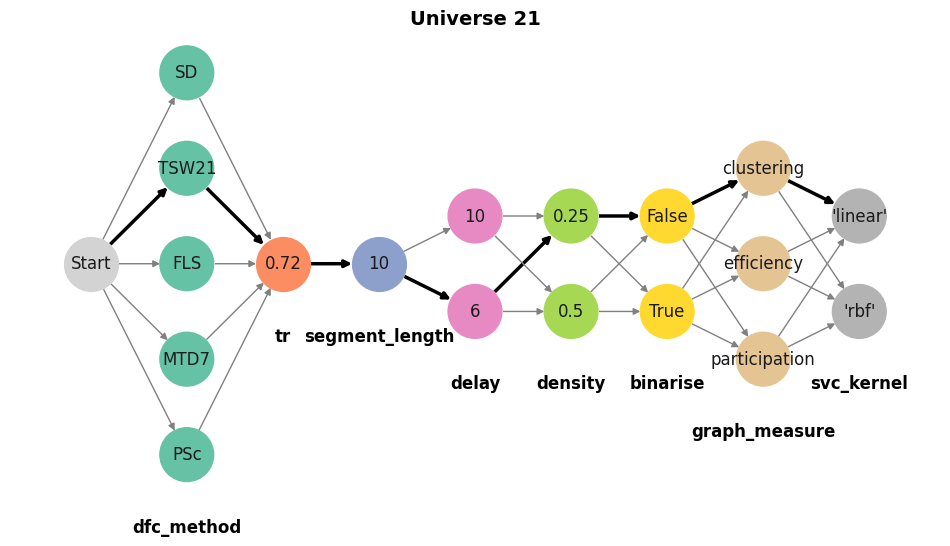

In [ ]:
mverse.summary()
mverse.visualize(universe=21, figsize=(12, 6));

Plot the specififcation curve. This can be done in two ways:

1) From .pkl results files of each universe saved in the main analysis template (see above). The ```measure``` argument has to be the name of the outcome variable.
2) From a single .csv file, with the results being an additional column

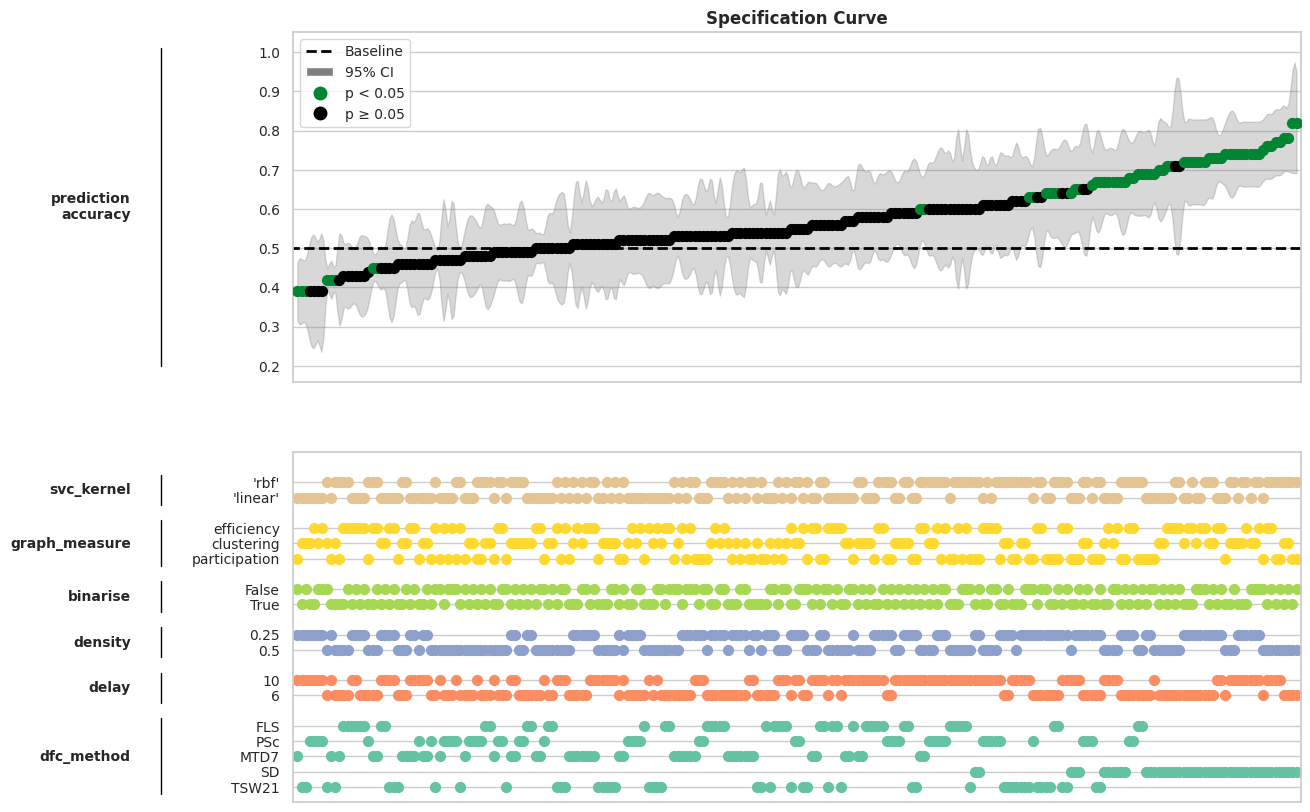

In [5]:
mverse.specification_curve(measure="prediction\naccuracy", title="Specification Curve", \
                           baseline=0.5, p_value=0.05, ci=95, smooth_ci=True, \
                           cmap="Set2", figsize=(13,10), fontsize=10, height_ratio=[1,1]);